In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import lingam
from causalnex.structure.dynotears import from_pandas_dynamic
from tigramite import data_processing as pp
from tigramite.independence_tests import cmiknn
from tigramite.pcmci import PCMCI
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

plt.style.use('ggplot')

/Users/danieloliveira/opt/anaconda3/envs/cml-fin/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv(os.path.join(os.getcwd(), 'processedData', 'monetary-policy-processed.csv'))
data = data.drop(["Unnamed: 0"], axis=1)
data["date"] = pd.to_datetime(data["date"])
data.set_index("date", inplace=True)

y = data[["ldEXME"]]
X = data.drop(["ldEXME"], axis=1)

In [3]:
X.tail()

,dCMR,ldFCIr,ldRIMFr,ldMAr,ldCHFr,ldtotOAr,ldGDPch,ldGDPeu,dCPI
date,,,,,,,,,
2016-09-01,7.281406,-0.022146,-0.211913,-0.156114,-0.036033,-0.090568,-0.706264,-0.125753,0.033092
2016-10-01,0.292451,-0.018670,0.216994,-0.062544,0.227075,-0.145615,-0.121392,-0.127636,0.022964
2016-11-01,-0.110758,0.049250,-0.008647,2.409139,-0.413748,-0.074912,0.469814,-0.129512,0.058117
2016-12-01,0.023645,-0.005983,-0.066078,-0.686351,-0.104817,-0.088863,-0.355198,-0.131379,-7.767846
2017-01-01,0.023645,-0.092584,0.331965,0.247863,0.348206,-0.166479,-0.103644,-0.133239,0.159838


In [4]:
y.tail()

,ldEXME
date,
2016-09-01,0.543000
2016-10-01,-0.100097
2016-11-01,0.128386
2016-12-01,0.124207
2017-01-01,0.325720


<Axes: xlabel='date'>

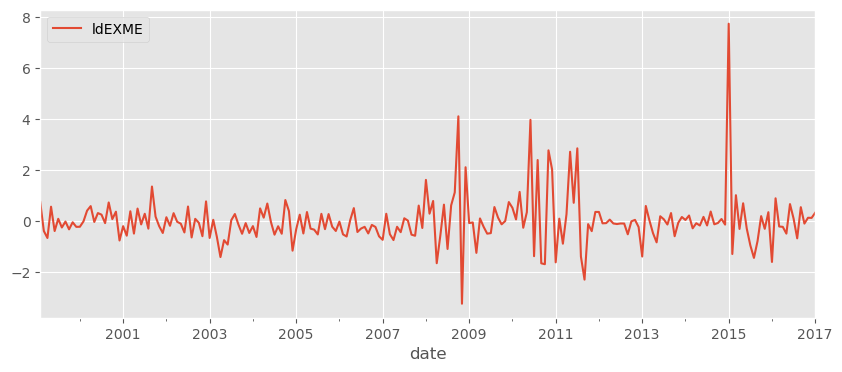

In [5]:
y.plot(figsize=(10, 4))

<Axes: xlabel='date'>

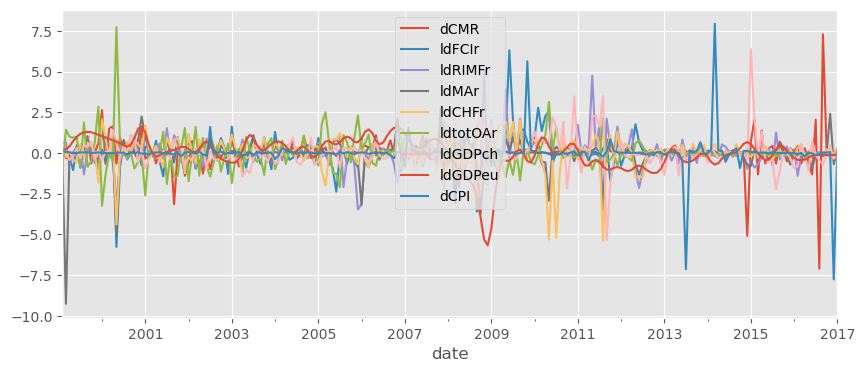

In [6]:
X.plot(figsize=(10, 4))

## 1) VAR-LiNGAM

In [7]:
p = 4
target = "ldEXME"
data = pd.concat([y, X], axis=1)

# run VAR-LiNGAM
var_lingam = lingam.VARLiNGAM(lags=p, criterion="none")
var_lingam_fit = var_lingam.fit(data)

# map coefficients to names
labels = {}
Bs = []
chosen_p = len(var_lingam_fit._adjacency_matrices)
for i in range(chosen_p):

    var_names = []
    for colname in data.columns:
        if i == 0:
            var_names.append(f"{colname}(t)")
        else:
            var_names.append(f"{colname}(t-{i})")
    labels[f'labels{i}'] = var_names

    B = var_lingam_fit._adjacency_matrices[i]
    B_df = pd.DataFrame(B, columns=labels[f'labels{i}'] , index=labels['labels0'] )

    Bs.append(pd.DataFrame(B_df.loc[f"{target}(t)"]).reset_index().melt([f"{target}(t)"]).rename(columns={f"{target}(t)": "betas"}).drop("variable", axis=1)[["value", "betas"]])

In [8]:
# VAR-LiNGAM - ldGDPch, ldEXME, ldCHFr
varlingam_features = pd.DataFrame({"feature": ["ldGDPch", "ldEXME", "ldCHFr"]})
varlingam_features["betas"] = 1
varlingam_features["model"] = "varlingam"

pd.concat(Bs, axis=1)

,value,betas,value,betas,value,betas,value,betas,value,betas
0,ldEXME(t),0.000000,ldEXME(t-1),-0.644364,ldEXME(t-2),0.100669,ldEXME(t-3),0.0,ldEXME(t-4),0.0
1,dCMR(t),0.000000,dCMR(t-1),0.000000,dCMR(t-2),0.000000,dCMR(t-3),0.0,dCMR(t-4),0.0
2,ldFCIr(t),0.000000,ldFCIr(t-1),0.000000,ldFCIr(t-2),0.000000,ldFCIr(t-3),0.0,ldFCIr(t-4),0.0
3,ldRIMFr(t),0.000000,ldRIMFr(t-1),0.000000,ldRIMFr(t-2),0.000000,ldRIMFr(t-3),0.0,ldRIMFr(t-4),0.0
4,ldMAr(t),0.000000,ldMAr(t-1),0.000000,ldMAr(t-2),0.000000,ldMAr(t-3),0.0,ldMAr(t-4),0.0
5,ldCHFr(t),0.000000,ldCHFr(t-1),-0.143742,ldCHFr(t-2),0.000000,ldCHFr(t-3),0.0,ldCHFr(t-4),0.0
6,ldtotOAr(t),0.000000,ldtotOAr(t-1),0.000000,ldtotOAr(t-2),0.000000,ldtotOAr(t-3),0.0,ldtotOAr(t-4),0.0
7,ldGDPch(t),0.937311,ldGDPch(t-1),0.000000,ldGDPch(t-2),0.000000,ldGDPch(t-3),0.0,ldGDPch(t-4),0.0
8,ldGDPeu(t),0.000000,ldGDPeu(t-1),0.000000,ldGDPeu(t-2),0.000000,ldGDPeu(t-3),0.0,ldGDPeu(t-4),0.0
9,dCPI(t),0.000000,dCPI(t-1),0.000000,dCPI(t-2),0.000000,dCPI(t-3),0.0,dCPI(t-4),0.0


## 2) Dynotears

In [21]:
p = 4
data = pd.concat([y, X], axis=1)
data = data.reset_index(drop=True)

# run DYNOTEARS
dynotears = from_pandas_dynamic(data, p=p)

edges_df = pd.DataFrame(dynotears.edges(), columns=['to', 'from'])[['from', 'to']]
edges_df["from_lag"] = edges_df["from"].apply(lambda x: int(x.split("_")[1][-1]))
edges_df["to_lag"] = edges_df["to"].apply(lambda x: int(x.split("_")[1][-1]))

edges_df["new_from"] = edges_df["from"].apply(lambda x: x.split("_")[0])
edges_df["new_to"] = edges_df["to"].apply(lambda x: x.split("_")[0])

# # select valid edges
# edges_df = edges_df.loc[(edges_df["from_lag"] == 0) & (edges_df["to_lag"] != 0)]

# build adjacency matrix
adj = []
for from_node in edges_df.loc[edges_df["from_lag"] == 0]["new_from"].unique():
    tmp_from = edges_df.loc[edges_df["new_from"] == from_node]
    col_names = []
    for idx, row in tmp_from.iterrows():
        col_names.append(f"{row['new_to']}(t-{row['to_lag']})")
    row_name = from_node

    tmp_adj = pd.DataFrame(1, columns=col_names, index=[f"{row_name}(t)"])
    adj.append(tmp_adj)
if len(adj) > 0:
    adj_df = pd.concat(adj).fillna(0)
else:
    adj_df = pd.DataFrame(0, columns=data.columns, index=data.columns)

target_adj_df = pd.DataFrame(adj_df.loc[f"{target}(t)"]).reset_index().rename(columns={f"{target}(t)": "betas", "index": "value"})

In [22]:
# Dynotears - ldGDPeu, ldEXME, ldCHFr, ldGDPch
dynotears_features = pd.DataFrame({"feature": ["ldGDPeu", "ldEXME", "ldCHFr", "ldGDPch"]})
dynotears_features["betas"] = 1
dynotears_features["model"] = "dynotears"

target_adj_df

,value,betas
0,ldEXME(t-0),0.0
1,ldFCIr(t-1),0.0
2,ldFCIr(t-3),0.0
3,ldCHFr(t-2),0.0
4,ldCHFr(t-3),0.0
5,ldtotOAr(t-0),0.0
6,ldEXME(t-1),1.0
7,ldRIMFr(t-0),0.0
8,ldRIMFr(t-4),0.0
9,ldGDPch(t-1),0.0


## 3) PCMCI

In [165]:
p = 4
pval_threshold = 0.05
data = pd.concat([y, X], axis=1)
data = data.reset_index(drop=True)

data_train_tigramite = pp.DataFrame(data.values, var_names=data.columns)

pcmci = PCMCI(dataframe=data_train_tigramite, cond_ind_test=cmiknn.CMIknn(), verbosity=0)
pcmci.run_pcmci(tau_min=0, tau_max=p, pc_alpha=pval_threshold)

parents_set = dict()
for effect in pcmci.all_parents.keys():
    parents_set[pcmci.var_names[effect]] = []
    for cause, t in pcmci.all_parents[effect]:
        parents_set[pcmci.var_names[effect]].append((pcmci.var_names[cause], t))

In [170]:
target

'ldEXME'

In [169]:
parents_set.keys()

dict_keys(['ldEXME', 'dCMR', 'ldFCIr', 'ldRIMFr', 'ldMAr', 'ldCHFr', 'ldtotOAr', 'ldGDPch', 'ldGDPeu', 'dCPI'])

In [172]:
parents_set

{'ldEXME': [],
 'dCMR': [('dCMR', -1), ('dCMR', -3)],
 'ldFCIr': [('ldFCIr', -6),
  ('ldFCIr', -1),
  ('ldFCIr', -2),
  ('ldFCIr', -5),
  ('ldtotOAr', -4)],
 'ldRIMFr': [('ldFCIr', -6), ('ldFCIr', -1)],
 'ldMAr': [('ldMAr', -6), ('ldFCIr', -6)],
 'ldCHFr': [('ldFCIr', -1), ('ldFCIr', -6)],
 'ldtotOAr': [('ldFCIr', -5),
  ('ldFCIr', -2),
  ('ldtotOAr', -3),
  ('ldtotOAr', -1)],
 'ldGDPch': [('ldEXME', -1), ('ldEXME', -3)],
 'ldGDPeu': [('ldGDPeu', -1), ('ldtotOAr', -2)],
 'dCPI': [('dCPI', -1), ('dCPI', -2)]}

In [171]:
parents_set[target]

[]

In [23]:
# pcmci - []
pcmci_features = pd.DataFrame({"feature": []})
pcmci_features["betas"] = 1
pcmci_features["model"] = "pcmci"

## 4) Multivariate granger

In [13]:
p = 4
pval_threshold = 0.05
data = pd.concat([y, X], axis=1)
data = data.reset_index(drop=True)

# run grander causality test for each feature
var_fit = VAR(data).fit(maxlags=p)

# run grander causality test for each feature
selected_variables = []
for colname in data.columns:
    if colname != target:
        test_result = var_fit.test_causality(target, [colname], kind='f', signif=pval_threshold)
        if test_result.pvalue <= pval_threshold:
            for lag in range(1, p + 1):
                selected_variables += [f"{colname}(t-{lag})"]               


In [14]:
selected_variables

['ldFCIr(t-1)',
 'ldFCIr(t-2)',
 'ldFCIr(t-3)',
 'ldFCIr(t-4)',
 'ldCHFr(t-1)',
 'ldCHFr(t-2)',
 'ldCHFr(t-3)',
 'ldCHFr(t-4)',
 'ldGDPch(t-1)',
 'ldGDPch(t-2)',
 'ldGDPch(t-3)',
 'ldGDPch(t-4)']

In [15]:
# mvgranger - ldGDPch
mvgranger_features = pd.DataFrame({"feature": ["ldGDPch"]})
mvgranger_features["betas"] = 1
mvgranger_features["model"] = "mvgranger"

## 5) Pairwise Granger

In [16]:
p = 4
incercept = False
pval_threshold = 0.05
data = pd.concat([y, X], axis=1)
data = data.reset_index(drop=True)

selected_variables = []
# run grander causality test for each feature
for colname in data.columns:
    test_result = grangercausalitytests(x=data[[target, colname]], maxlag=p, verbose=False)

    # select variables with p-value < 0.05
    for lag in test_result.keys():
        pval = test_result[lag][0]['ssr_ftest'][1]
        if pval <= pval_threshold:
            selected_variables += [f"{colname}(t-{lag})"]

/Users/danieloliveira/opt/anaconda3/envs/cml-fin/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/danieloliveira/opt/anaconda3/envs/cml-fin/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/danieloliveira/opt/anaconda3/envs/cml-fin/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/danieloliveira/opt/anaconda3/envs/cml-fin/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/danieloliveira/opt/anaconda3/envs/cml-fin/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should 

In [17]:
selected_variables

['dCMR(t-1)', 'ldGDPch(t-2)']

In [18]:
# mvgranger - dCMR, ldGDPch
pwgranger_features = pd.DataFrame({"feature": ["dCMR", "ldGDPch"]})
pwgranger_features["betas"] = 1
pwgranger_features["model"] = "pwgranger"

## 6) seqICP

In [25]:
seqicp_features = pd.DataFrame({"feature": ["ldFCIr", "ldGDPch"]})
seqicp_features["betas"] = 1
seqicp_features["model"] = "seqicp"

## All Features

In [26]:
pd.concat([varlingam_features,
           dynotears_features,
           seqicp_features,
           pcmci_features,
           mvgranger_features,
           pwgranger_features], axis=0).pivot_table(columns=["feature"], index=["model"], values=["betas"])

betas                                     
feature    dCMR ldCHFr ldEXME ldFCIr ldGDPch ldGDPeu
model                                               
dynotears   NaN    1.0    1.0    NaN     1.0     1.0
mvgranger   NaN    NaN    NaN    NaN     1.0     NaN
pwgranger   1.0    NaN    NaN    NaN     1.0     NaN
seqicp      NaN    NaN    NaN    1.0     1.0     NaN
varlingam   NaN    1.0    1.0    NaN     1.0     NaN